
## Overview

This part executes EDA and the dataset based on the Top250 IMDB movie reviews data set. 


In [1]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

# Specify the current working directory
import os
 
# Here is the file path in google drive, and drive is the previously specified working root directory. Please add
os.chdir("/content/drive/MyDrive/Movie review project")

Mounted at /content/drive



## Installing and importing dependencies

First let us import all the modules and packages that will be required.


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip data.shapeinstall -q tensorflow-text

ERROR: unknown command "data.shapeinstall"


In [3]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 11.9 MB/s eta 0:00:00


In [4]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Loading and Exploring dataset







In [7]:
data = pd.read_csv(r'/content/drive/MyDrive/Movie review project/all_data.csv')

In [9]:
data.shape

(309018, 2)

In [23]:
data_cleaned= pd.read_csv(r'/content/drive/MyDrive/Movie review project/all_data_cleaned.csv')

In [24]:
data_cleaned.shape

(304950, 2)

Thus there are 304950 rows and 2 columns in the `data` dataframe 

In [25]:
data_cleaned.head(10)

,review,sentiment
0,I am normally loathe to agree with anything wr...,positive
1,I love Pixar films and I love superhero films ...,positive
2,I'd hate for a foreigner to see this movie and...,positive
3,One of the best movies I have ever seen. NO ot...,positive
4,To say this movie is a fever dream is an under...,positive
5,Greetings from hicflicks.wordpress.com !,positive
6,Was it really two and a half hours? I wanted ...,positive
7,This is one of the best or the best '80s film....,positive
8,It's a difficult word to cope with. It's a wor...,positive
9,I am surprised that this movie never got as mu...,positive


As we can see the `sentiment` column has 2 values:

   * Negative Sentiment
   * Postive Sentiment
  

In [26]:
data_cleaned.isnull().sum()

review       0
sentiment    0
dtype: int64

Now we encode the positive sentiment to 1 and negative sentiment to 0

In [27]:
labeling = {
    'positive':1, 
    'negative':0
}

data_cleaned['sentiment'] = data_cleaned['sentiment'].apply(lambda x : labeling[x])
# Output first ten rows
data_cleaned.head(10)


,review,sentiment
0,I am normally loathe to agree with anything wr...,1
1,I love Pixar films and I love superhero films ...,1
2,I'd hate for a foreigner to see this movie and...,1
3,One of the best movies I have ever seen. NO ot...,1
4,To say this movie is a fever dream is an under...,1
5,Greetings from hicflicks.wordpress.com !,1
6,Was it really two and a half hours? I wanted ...,1
7,This is one of the best or the best '80s film....,1
8,It's a difficult word to cope with. It's a wor...,1
9,I am surprised that this movie never got as mu...,1


Thus, there are no missing values in any of the columns of the dataset.

## EDA

<Axes: xlabel='sentiment'>

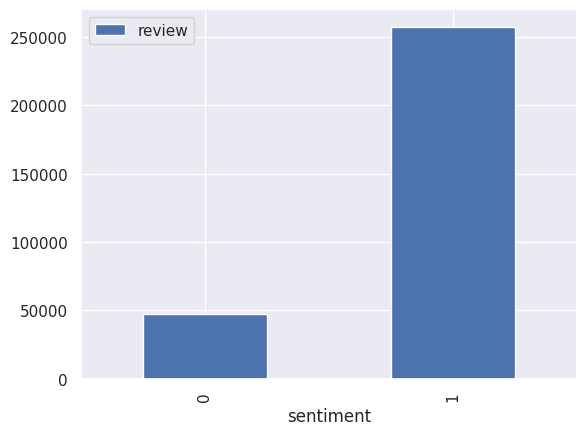

In [28]:
# The distribution of sentiments
data_cleaned.groupby('sentiment').count().plot(kind='bar')

<Axes: >

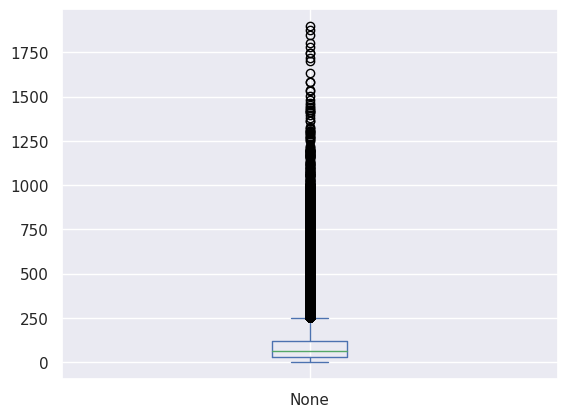

In [29]:
# Calculate review lengths
review_len = pd.Series([len(review.split()) for review in data_cleaned['review']])

# The distribution of review text lengths
review_len.plot(kind='box')

Now, let us visualize how long our sentences are in the training data.

<Axes: ylabel='Count'>

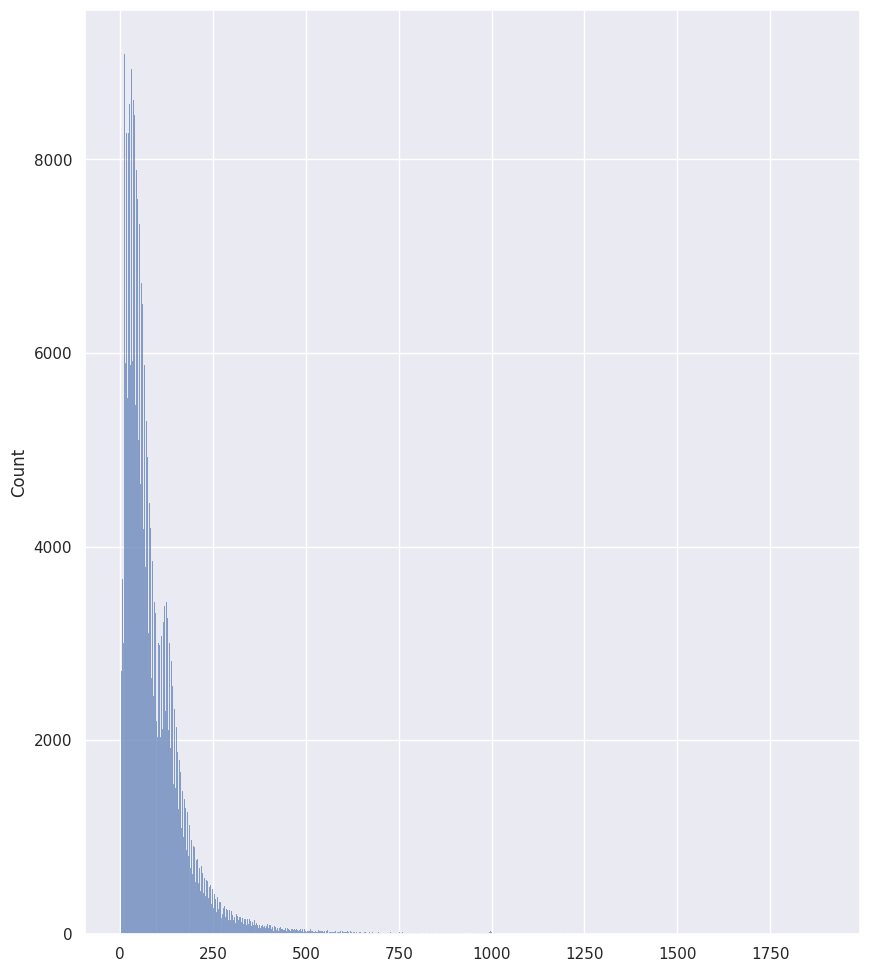

In [30]:
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None,
)

plt.figure(figsize = (10,12))
sns.histplot(review_len)

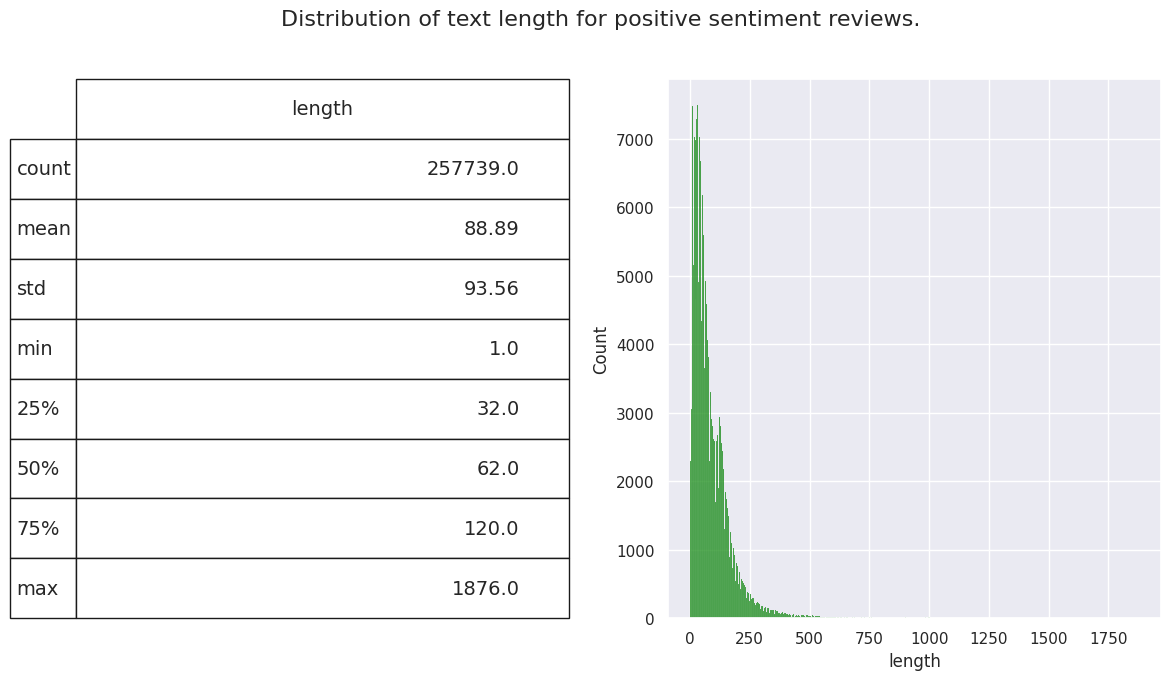

In [35]:
fig = plt.figure(figsize=(14,7))
data_cleaned['length'] = data_cleaned.review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(data_cleaned[data_cleaned['sentiment']==1]['length'], ax=ax1,color='green')
describe = data_cleaned.length[data_cleaned.sentiment==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment reviews.', fontsize=16)

plt.show()

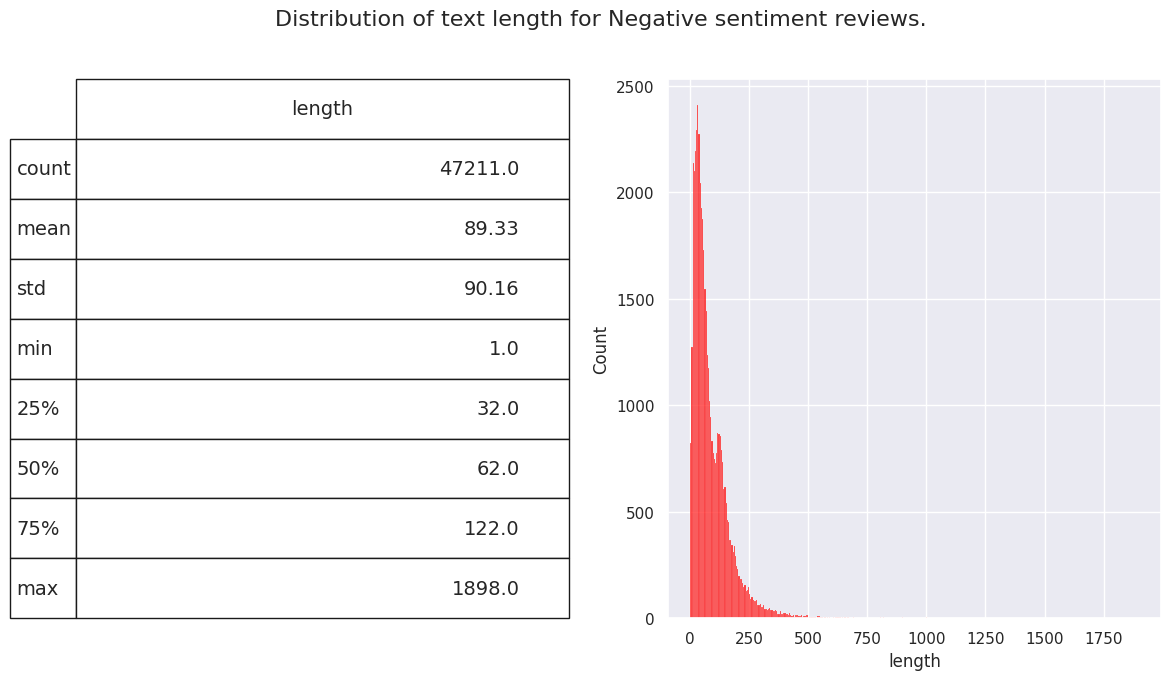

In [36]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(data_cleaned[data_cleaned['sentiment']==0]['length'], ax=ax1,color='red')
describe = data.length[data_cleaned.sentiment==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment reviews.', fontsize=16)

plt.show()

#### WORDCLOUD FOR NEGATIVE TEXT (LABEL - 0)

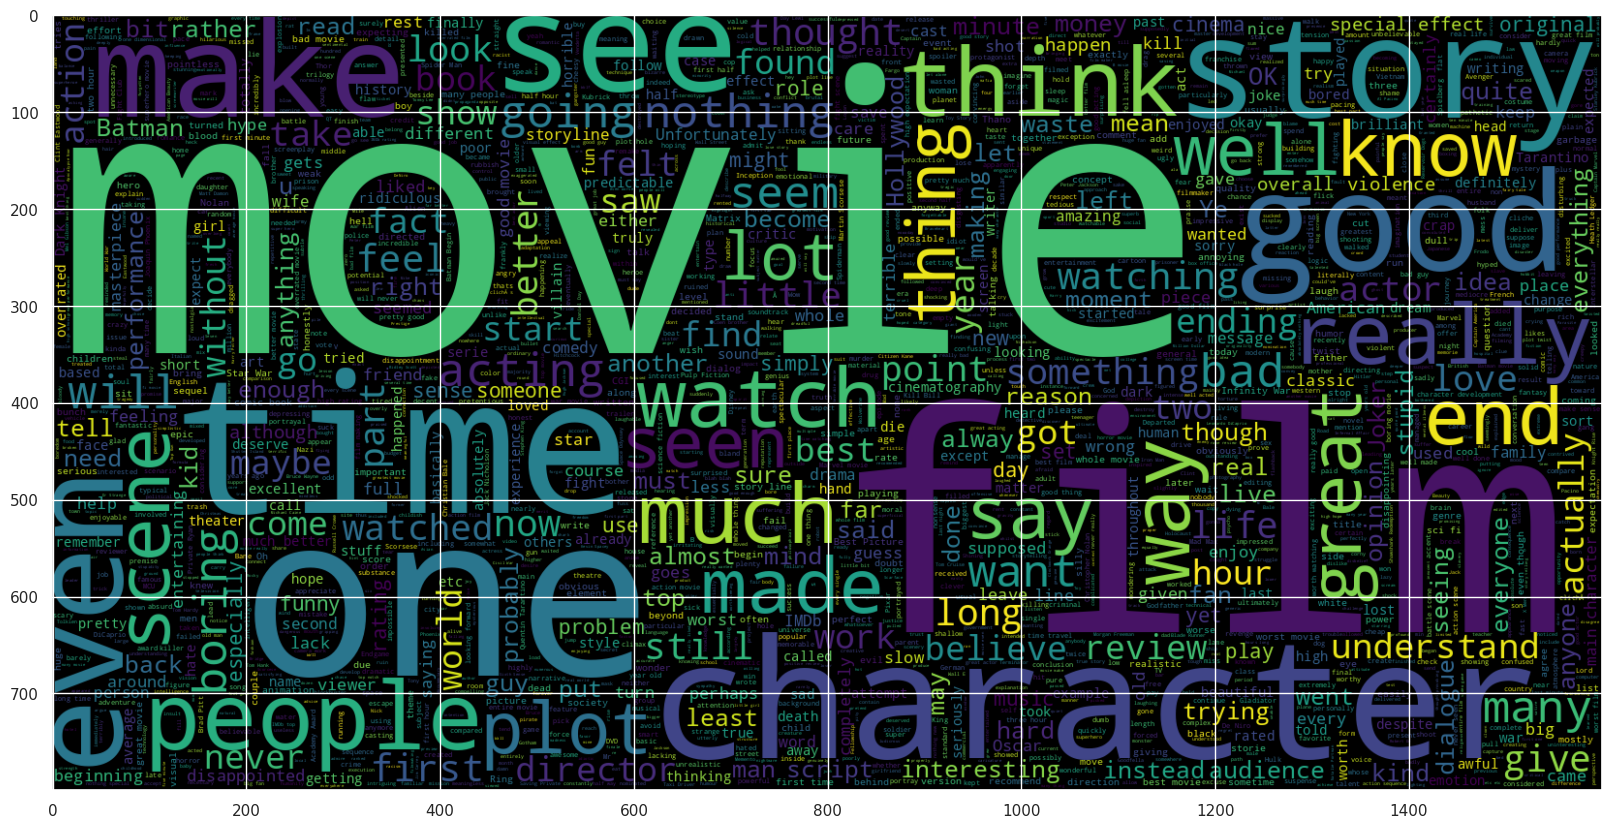

In [37]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_cleaned[data_cleaned.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

#### WORDCLOUD FOR POSITIVE TEXT (LABEL - 1)

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_cleaned[data_cleaned.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')